In [1]:
%matplotlib inline

import time

# math and data manipulation
import numpy as np
import pandas as pd
from tqdm import tqdm

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed
from tensorflow import keras

from csef.model import lstm
from csef.data import preprocessing, load_data
from csef.utils import performance
from csef.model.base import GeneralModel

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

/home/thuongdinh/.virtualenvs/mlcsef/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Data Loading

In [2]:
data_mapping = load_data.load_data()
consumption_train = data_mapping['consumption_train']
cold_start_test = data_mapping['cold_start_test']
submission_format = data_mapping['submission_format']
meta = data_mapping['meta']

## Training

In [3]:
load_data.describe_training_data(consumption_train)

There are 758 training series totaling 21224 days (509376 hours) of consumption data.


In [4]:
# Default config
n_batch = 1
n_input = 24
n_nodes = 24
lag = n_input
batch_input_shape = (n_batch, 1, n_input)

### Baseline model but go with 40 epoches 

In [5]:
config = {
    'n_input': n_input,
    'n_nodes': n_nodes,
    'n_batch': n_batch,
    'model': [
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': n_input,
                'batch_input_shape': batch_input_shape,
                'stateful': True
            }
        },
        {
            'layer_type': 'Dropout',
            'layer_config': {
                'rate': 0.01
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': n_input,
                'activation': 'tanh'
            }
        },
        {
            'layer_type': 'Dropout',
            'layer_config': {
                'rate': 0.01
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 1
            }
        }
    ]
}

In [6]:
model = GeneralModel(config)

In [ ]:
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 5

total_start_time = time.time()

epoch_timers = []

for i in range(num_passes_through_data):
    epoch_start_time = time.time()
    model.fit(consumption_train)
    epoch_timers.append((epoch_start_time, time.time()))
    
total_end_time = time.time()

Fitting the data:  68%|██████▊   | 516/758 [13:11<06:12,  1.54s/it]

In [1]:
total_end_time - total_start_time

NameError: name 'total_end_time' is not defined

In [9]:
model_path = Path('..', '..', 'data', 'model')
model_path.mkdir(exist_ok=True, parents=True)
keras.models.save_model(
    model.model,
    model_path / 'release-006-01-20181025.hdf5'
)

In [10]:
my_submission = model.make_submission(submission_format, cold_start_test)

Forecasting from Cold Start Data: 100%|██████████| 625/625 [07:09<00:00,  1.40it/s]


In [12]:
save_path = Path('..', '..', 'data', 'submissions')
save_path.mkdir(exist_ok=True, parents=True)
my_submission.to_csv(save_path / "release-006-01-20181025.csv", index_label='pred_id')

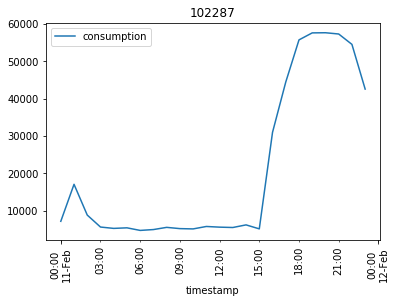

In [13]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

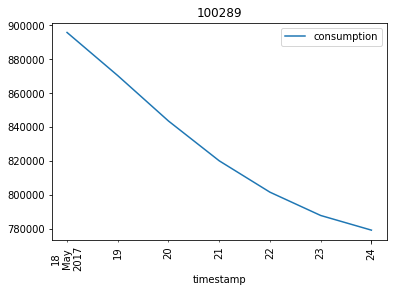

In [14]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'daily']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

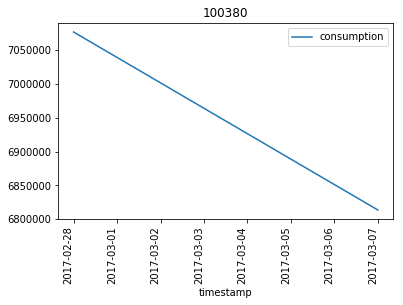

In [15]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'weekly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [16]:
my_submission[my_submission.series_id == sample_ser]

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
872,100380,2017-02-28,8.670238,7.077078e+06,weekly
873,100380,2017-03-07,7.772619,6.813566e+06,weekly
